# Lab Exercise 3: Matched Filters and L-ASK
After studying Chapter 3 and, in particular, Example 3.2 of the notes, copy Code 3.3 of this example into a file named ask_errors.m (the code is repeated here for convenience). Then execute the following:

## Setup

```{admonition} Live Code
Press the following button to make python code interactive. It will connect you to a kernel once it says "ready" (might take a bit, especially the first time it runs).
```

<div style="text-align: center;">
  <button title="Launch thebe" class="thebelab-button thebe-launch-button" onclick="initThebe()">Python Interactive Code</button>
</div>


#### Importing packages we will need later in Python

In [2]:
# Import necessary libraries for signal processing and visualization

from scipy import signal                 # Provides signal processing tools
import numpy as np                        # Fundamental package for numerical computations
import matplotlib.pyplot as plt           # Plotting library for creating static, animated, and interactive visualizations
from scipy.special import erfc            # Contains the complementary error function and other special functions
import ipywidgets as widgets              # Enables the use of interactive HTML widgets in Jupyter notebooks
from ipywidgets import RadioButtons       # Widget for creating radio button groups
from IPython.display import display, clear_output  # Functions to display output and clear cell outputs
from scipy.signal import upfirdn, convolve # Functions for resampling and convolution operations
from ipywidgets import Checkbox, Button, Output, VBox, HBox, Dropdown, Layout  # Widgets for interactive controls and layout management
import time                               # Time-related functions for handling timing and delays

# Confirmation message indicating successful import of libraries
print("Libraries added successfully!")

Libraries added successfully!


## Part 1: Theory

#### Code 3.3: Calculation of the probability of erroneous symbol for coherent ASK with orthogonal

````` {admonition} Code 3.3
````{tab} Python
```python

import numpy as np

def ask_errors(k, M, nsamp, EbN0_db):
    # L is the number of different amplitude levels (2^k)
    L = 2**k
    # Calculate SNR in dB adjusting for number of samples and bits per symbol
    SNR_db = EbN0_db - 10*np.log10(nsamp/2/k)
    # Convert SNR from dB to linear scale
    SNR = 10 ** (SNR_db * 0.1)
    # Generate a vector of random symbols with amplitudes {±1, ±3, ... ±(L-1)}
    x = 2*np.floor(L*np.random.rand(M)) - L + 1
    # Theoretical signal power
    P_x = (L**2-1) / 3
    # Measured signal power (for verification)
    Measured_x = np.sum(x*x)/len(x)

    # Generate oversampled signal y by repeating each symbol nsamp times
    y = []
    for i in range(len(x)):
        for j in range(nsamp):
            y.append(x[i])
    y = np.array(y)

    # Generate noise with zero mean and variance based on the signal power and SNR
    noise = np.random.normal(0, np.sqrt(Measured_x/SNR), len(y))
    # Add noise to the signal
    y_noisy = y + noise

    # Reshape the noisy signal for matched filtering
    y = np.reshape(y_noisy, (M, nsamp))
    # Create a matched filter with coefficients all ones
    matched = np.ones((nsamp, 1))
    # Apply matched filter to the signal
    z = np.matmul(y, matched)
    z = z / nsamp
    # Levels for decision making {±1, ±3, ... ±(L-1)}
    l = np.arange(-L+1, L, 2)

    # Decision making: for each symbol, find the closest amplitude level
    z = z[:, 0]
    for i in range(len(z)):
        differences = np.abs(l - z[i]) # Array of differences from the signal to the levels
        m = min(differences)
        [index], = np.where(differences == m)
        z[i] = l[index]
    
    # Count errors: compare the decided symbols with the original symbols
    errors = 0
    for i in range(len(z)):
        if x[i] != z[i]:
            errors += 1
    
    # Return the total number of symbol errors
    return errors

```
````
````{tab} Matlab
```matlab

function errors=ask_errors(k, Nsymb, nsamp, EbNo)
% This function simulates the generation and decoding
% of a noisy L-ASK signal and counts the number of erroneous symbols.
% It returns the number of erroneous symbols (in the variable errors).
% k is the number of bits/symbol, therefore L=2^k -- the number of
% different amplitudes
% Nsymb is the number of generated symbols (length of LASK sequence)
% nsamp is the number of samples per symbol (oversampling ratio)
% EbNo is the normalized signal-to-noise ratio Eb/No, in dB
%
L=2^k;
SNR=EbNo-10*log10(nsamp/2/k); % SNR per signal sample
% Vector of random integers {±1, ±3, ... ±(L-1)}. To be verified
x=2*floor(L*rand(1, Nsymb))-L+1;
Px=(L^2-1)/3; % theoretical signal power
sum(x.^2)/length(x); % measured signal power (for verification)
y=rectpulse(x, nsamp);
n=wgn(1, length(y), 10*log10(Px)-SNR);
ynoisy=y+n; % noisy signal
y=reshape(ynoisy, nsamp, length(ynoisy)/nsamp);
matched=ones(1, nsamp);
z=matched*y/nsamp;
A=[-L+1:2:L-1];
for i=1:length(z)
    [m, j]=min(abs(A-z(i)));
    z(i)=A(j);
end
err=not(x==z);
errors=sum(err);
end

```
````
`````

## Part 2: Simulation Code Exploration

(a) Modify the code so that the L elements of vector x in line 14 take values from the set {±d/2, ±3d/2, ±5d/2...}, where the distance d of the points will be given as a parameter. Using the value d=5, verify by calculation and displaying a relevant histogram, that the elements of vector x indeed follow a uniform distribution. Use k=mod(nnnnn,2)+3, where nnnnn is the last 5-digit part of your registration number.

Hint: Generate (with command 14) at least 40,000 random integers, and use the command hist(x,A) to calculate and display the histogram, where A is the vector of the L different values of these integers. Modify command 15 appropriately for the theoretical calculation of power and verify with command 16. Similarly, modify command 23 appropriately.

In [10]:
# Loading animation HTML code for visual feedback during processing
# This HTML code creates a spinning loader animation to indicate that processing is ongoing
loading = """
    <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
        <div class='loader' style='border: 12px solid #f3f3f3; /* Light grey border */
                                     border-top: 12px solid #01cc97; /* Blue border on top */
                                     border-radius: 50%;             /* Circular shape */
                                     width: 40px;
                                     height: 40px;
                                     animation: spin 2s linear infinite; /* Spinning animation */'></div>
    </div>
    <style>
    @keyframes spin {
        0% { transform: rotate(0deg); }     /* Start rotation at 0 degrees */
        100% { transform: rotate(360deg); } /* Full rotation (360 degrees) */
    }
    </style>
    """

# HTML code to display a checkmark when loading is complete
# This code shows a green checkmark indicating that processing has finished
done = """
    <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
        <div style='font-size: 40px; color: #01cc97;'>&#10003;</div>  <!-- Unicode checkmark symbol -->
    </div>
    """

# Create HTML widgets to display the loading animation and elapsed time
loader_html1 = widgets.HTML(
  value=loading  # Initially display the loading animation
)
timer_html1 = widgets.HTML(
    value="Elapsed time: - seconds"  # Placeholder for the elapsed time display
)

def generate_histogram(k, d):
    """
    This function generates a histogram based on user-specified parameters 'k' and 'd'.

    Parameters:
    - k (int): Determines the number of quantization levels L = 2^k.
    - d (float): The distance between quantization levels.

    The function performs the following steps:
    1. Generates M random samples uniformly distributed over the quantization levels.
    2. Calculates the appropriate bins for the histogram based on 'L' and 'd'.
    3. Plots the histogram showing the frequency of each quantized value.
    4. Displays a loading animation while processing and shows the elapsed time after completion.
    """

    # Start the timer and show the loading animation
    loader_html1.value = loading
    start_time = time.time()

    M = 40000       # Number of random samples to generate
    L = 2 ** k      # Calculate L as 2 raised to the power of k, determining the number of levels

    # Generate M random samples uniformly distributed over the quantization levels
    # The quantization levels are centered around zero and spaced by 'd'
    # x will contain values like -L*d/2 + d/2, -L*d/2 + 3d/2, ..., L*d/2 - d/2
    x = (2 * np.floor(L * np.random.rand(M)) - L + 1) * d / 2

    # Define the bins for the histogram
    bins = np.arange(-L*d/2, L*d/2 + d, d)      # Bin edges from -L*d/2 to L*d/2 with step size 'd'
    A = np.arange(-L*d/2 + d/2, L*d/2, d)       # Positions for x-ticks at the center of each bin

    # Create a figure and axis for the histogram
    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    # Plot the histogram of x with specified bins and visual style
    ax.hist(x, bins=bins, edgecolor='white', color='#1F77B4')
    ax.set_xticks(A)                    # Set the x-ticks to the centers of the bins
    ax.set_xlabel("Integers")           # Label for the x-axis
    ax.set_ylabel("Frequency")          # Label for the y-axis
    ax.set_title("Histogram of array x elements")  # Title of the plot

    # Calculate and display the elapsed time
    elapsed_time = time.time() - start_time
    timer_html1.value = f"Elapsed time: {elapsed_time:.2f} seconds"
    loader_html1.value = done           # Replace the loading animation with the completion checkmark

    plt.show()                          # Display the plot

# UI Components for user input
k_input = widgets.IntText(
    value=3,                        # Default value for k
    description='k:',               # Label for the input widget
    continuous_update=False         # Update only when the user presses Enter or moves away from the field
)
d_input = widgets.FloatText(
    value=1,                        # Default value for d
    description='d:',               # Label for the input widget
    continuous_update=False         # Update only when the user presses Enter or moves away from the field
)

inputs = widgets.VBox([k_input, d_input])  # Arrange the input widgets vertically

# Group the loader and timer together; they will appear next to each other horizontally
loader_timer_box = widgets.VBox(
    [loader_html1, timer_html1],
    layout=widgets.Layout(margin='0 0 0 20px', width='auto')  # Add left margin and auto width
)

# Arrange the input widgets and loader/timer horizontally
ui = widgets.HBox(
    [inputs, loader_timer_box],
    layout=Layout(align_items='center')  # Center the items vertically
)

# Create an interactive output that updates when 'k' or 'd' changes
out = widgets.interactive_output(generate_histogram, {'k': k_input, 'd': d_input})

# Display the UI components and the output area
display(ui, out)


Output()

(b) With parameter values of the function k=4, M=60000, nsamp=20, and EbNo=12, execute commands 11 to 22 and then plot the histogram of z with the command hist(z,200). Repeat the above for EbNo=16 and EbNo=20. What do you observe? Explain the differences in the three diagrams.

In [11]:
# Loading animation HTML code for visual feedback during processing
# This HTML code creates a spinning loader animation to indicate that processing is ongoing
loading = """
    <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
        <div class='loader' style='border: 12px solid #f3f3f3; /* Light grey border */
                                     border-top: 12px solid #01cc97; /* Blue border on top */
                                     border-radius: 50%;             /* Circular shape */
                                     width: 40px;
                                     height: 40px;
                                     animation: spin 2s linear infinite; /* Spinning animation */'></div>
    </div>
    <style>
    @keyframes spin {
        0% { transform: rotate(0deg); }     # Start rotation at 0 degrees
        100% { transform: rotate(360deg); } # Full rotation (360 degrees)
    }
    </style>
    """

# HTML code to display a checkmark when loading is complete
# This code shows a green checkmark indicating that processing has finished
done = """
        <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
            <div style='font-size: 40px; color: #01cc97;'>&#10003;</div>  <!-- Unicode checkmark symbol -->
        </div>
        """

# Create HTML widgets to display the loading animation and elapsed time
loader_html2 = widgets.HTML(
  value=loading  # Initially display the loading animation
)
timer_html2 = widgets.HTML(
    value="Elapsed time: - seconds"  # Placeholder for the elapsed time display
)

def generate_histogram(k, EbN0_db, d):
    """
    This function generates a histogram of a noisy signal after passing through a matched filter.

    Parameters:
    - k (int): Number of bits per symbol (determines the modulation order L = 2^k)
    - EbN0_db (float): Energy per bit to noise power spectral density ratio in decibels
    - d (float): Minimum distance between signal constellation points

    The function performs the following steps:
    1. Generates random symbols according to the specified modulation order.
    2. Adds white Gaussian noise to the upsampled signal based on the specified Eb/N0.
    3. Passes the noisy signal through a matched filter.
    4. Plots the histogram of the matched filter output.
    """
    # Start timer and show the loading animation
    loader_html2.value = loading
    start_time = time.time()

    M = 60000    # Number of symbols to simulate
    nsamp = 16   # Oversampling factor (number of samples per symbol)

    L = 2 ** k   # Modulation order (number of signal levels)
    # Calculate SNR in dB based on Eb/N0 and oversampling factor
    SNR_db = EbN0_db - 10 * np.log10(nsamp / (2 * k))
    SNR = 10 ** (SNR_db * 0.1)  # Convert SNR from dB to linear scale

    # Generate random symbols from the constellation points
    x = (2 * np.floor(L * np.random.rand(M)) - L + 1) * d / 2
    # Calculate theoretical power of the signal
    Px = (d ** 2 / 4) * (L ** 2 - 1) / 3
    # Measure the actual power of the generated symbols
    Measured_x = np.sum(x ** 2) / len(x)

    # Upsample the signal by repeating each symbol nsamp times
    y = np.repeat(x, nsamp)

    # Generate white Gaussian noise with calculated variance based on SNR
    noise = np.random.normal(0, np.sqrt(Measured_x / SNR), len(y))
    y_noisy = y + noise  # Add noise to the upsampled signal

    # Reshape the noisy signal into a matrix where each row corresponds to one symbol
    y_reshaped = np.reshape(y_noisy, (M, nsamp))
    matched = np.ones((nsamp, 1))  # Matched filter coefficients (all ones)

    # Apply the matched filter to each symbol by matrix multiplication
    z = np.matmul(y_reshaped, matched) / nsamp  # Average over nsamp samples

    # Define the positions for x-ticks based on the constellation points
    A = np.arange(-(L - 1) * d / 2, L * d / 2, d)  # Correct range for ticks

    # Plot the histogram of the matched filter output
    fig, ax = plt.subplots(1, 1, figsize=(14, 4))
    ax.hist(z, bins=200, edgecolor='white', color='#1F77B4')
    ax.set_xticks(A)
    ax.set_xlabel("Integers")
    ax.set_ylabel("Frequency")
    ax.legend(["Eb/N0 = " + str(EbN0_db)])
    ax.set_title('Histogram of the Noisy Signal')

    # Calculate and display the elapsed time
    elapsed_time = time.time() - start_time
    timer_html2.value = f"Elapsed time: {elapsed_time:.2f} seconds"
    loader_html2.value = done  # Replace the loading animation with the completion checkmark

    plt.show()  # Display the plot

# UI Components for user input
k_input = widgets.IntText(
    value=3,                        # Default value for k
    description='k:',               # Label for the input widget
    continuous_update=False         # Update only when the user presses Enter or moves away from the field
)
d_input = widgets.IntText(
    value=5,                        # Default value for d
    description='d:',               # Label for the input widget
    continuous_update=False         # Update only when the user presses Enter or moves away from the field
)
EbN0_db_slider = widgets.FloatSlider(
    value=12,                       # Default value for Eb/N0 in dB
    min=0,
    max=20,
    step=0.1,
    description='Eb/N0 (dB):',      # Label for the slider
    continuous_update=False         # Update only when the user releases the slider
)

# Arrange the input widgets vertically
inputs = widgets.VBox([k_input, d_input, EbN0_db_slider])

# Group the loader and timer together; they will appear next to each other horizontally
loader_timer_box = widgets.VBox(
    [loader_html2, timer_html2],
    layout=widgets.Layout(margin='0 0 0 20px', width='auto')  # Add left margin and auto width
)

# Arrange the inputs and loader/timer horizontally
ui = widgets.HBox(
    [inputs, loader_timer_box],
    layout=Layout(align_items='center')  # Center the items vertically
)

# Create an interactive output that updates when any input changes
out = widgets.interactive_output(
    generate_histogram,
    {'k': k_input, 'd': d_input, 'EbN0_db': EbN0_db_slider}
)

# Display the UI components and the output area
display(ui, out)


Output()

(c) What does command 20 do and what does command 22 do? What type and dimension are the variables: x in command 14, y in command 17, y in command 20, matched, z, err, and errors?

(d) Explain the operation of the loop 24-27 of Code 3.3 as a minimum distance detector for L-ASK.

## Part 3: Performance Curves (BER as a function of the signal-to-noise ratio)

Verify the curve of Figure 3.10 of the notes (for convenience repeated below) for L-ASK, with L=2k, k=mod(nnnnn, 2)+3, where nnnnn is the last 5-digit part of your registration number. Plot the theoretical curve and superimpose the simulation results (discrete points), as in the figure. 'Read' from the 8-ASK curve and write in the submission file the BER values for Eb/No={8,14,18}db. Conversely, find the appropriate Eb/No value for an 8-ASK system with a transmission rate of R=1Mbps, so that the error rate does not exceed the value {10, 100, 1000} bps.

![lab3_1.png](../content/images/lab3_1.png)

This should be done in two ways:

(a) With your main program, which (i) will plot the curve using equation (3.33) of the notes and the approximation BER≈Pe/log2L, and (ii) will appropriately call the function ask_errors() for calculating the discrete points.


$
P_e = \frac{L-1}{L} \cdot \text{erfc}\left( \sqrt{\frac{3 \log_2 L  }{L^2 - 1} \cdot \frac{E_{b,av}}{N_o}} \right)
$


(where Pe is the false symbol probability)

Hint: (a) Call ask_errors(), once for each different value of EbNo, with a sufficiently high value of M (e.g., 20000) and calculate the error rate.

(b) Using the MATLAB BERTOOL tool. The tool is called by typing the bertool command in the MATLAB command window. In the window that appears, you should make the appropriate settings for each case, as indicated in the boxes below. As explained in Example 3.2 of the notes, bertool calls our function, ask_errors(), through the ask_ber_func.m function of code 3.4, in which appropriate values for the parameters k, Nsymb, and nsamp must be set. The files of both functions must be in the current folder (or in a folder that is in the path) of MATLAB.

```` {tab} Image 1
```{image} ../content/images/lab3_2.png
:align: center
```
````
```` {tab} Image 2
```{image} ../content/images/lab3_3.png
:align: center
```
````

````` {admonition} ask_ber_func()
````{tab} Python
```python


def ask_ber_func(EbNo_db, maxNumErrs, maxNumBits):
    # Initialize variables related to exit criteria
    totErr = 0  # Number of errors observed
    numBits = 0  # Number of bits processed

    # Set up parameters
    k = 3  # Number of bits per symbol
    Nsymb = 2000  # Number of symbols in each run
    nsamp = 16  # Oversampling, i.e., number of samples per T
    EbNo = 10 ** (EbNo_db / 10)  # Convert EbNo from dB to linear scale

    # Simulate until the number of errors exceeds maxNumErrs
    # or the number of bits processed exceeds maxNumBits
    while (totErr < maxNumErrs) and (numBits < maxNumBits):
        errors = ask_errors(k, Nsymb, nsamp, EbNo)
        # Assume Gray coding: 1 symbol error ==> 1 bit error
        totErr += errors
        numBits += k * Nsymb

    # Compute the BER
    ber = totErr / numBits
    return ber, numBits

```
````
````{tab} Matlab
```matlab

function [ber,numBits] = ask_ber_func(EbNo, maxNumErrs, maxNumBits)
% Import Java class for BERTool.
import com.mathworks.toolbox.comm.BERTool;
% Initialize variables related to exit criteria.
totErr = 0; % Number of errors observed
numBits = 0; % Number of bits processed
% --- Set up parameters. ---
% --- INSERT YOUR CODE HERE.
k=3; % number of bits per symbol
Nsymb=2000; % number of symbols in each run
nsamp=16; % oversampling,i.e. number of samples per T
% Simulate until number of errors exceeds maxNumErrs
% or number of bits processed exceeds maxNumBits.
while((totErr < maxNumErrs) && (numBits < maxNumBits))
% Check if the user clicked the Stop button of BERTool.
if (BERTool.getSimulationStop)
break;
end
% Β. --- INSERT YOUR CODE HERE.
errors=ask_errors(k,Nsymb,nsamp,EbNo);
% Assume Gray coding: 1 symbol error ==> 1 bit error
totErr=totErr+errors;
numBits=numBits + k*Nsymb;
end % End of loop
% Compute the BER
ber = totErr/numBits;


```
````
`````




In [12]:
# Loading animation HTML code for visual feedback during processing
# This HTML code creates a spinning loader animation to indicate that processing is ongoing

loading = """
    <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
        <div class='loader' style='border: 12px solid #f3f3f3; /* Light grey border */
                                     border-top: 12px solid #01cc97; /* Blue border on top */
                                     border-radius: 50%;             /* Circular shape */
                                     width: 40px;
                                     height: 40px;
                                     animation: spin 2s linear infinite; /* Spinning animation */'></div>
    </div>
    <style>
    @keyframes spin {
        0% { transform: rotate(0deg); }     /* Start rotation at 0 degrees */
        100% { transform: rotate(360deg); } /* Full rotation (360 degrees) */
    }
    </style>
    """

# HTML code to display a checkmark when loading is complete
# This code shows a green checkmark indicating that processing has finished

done = """
        <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
            <div style='font-size: 40px; color: #01cc97;'>&#10003;</div>  <!-- Unicode checkmark symbol -->
        </div>
        """

# Create HTML widgets to display the loading animation and elapsed time
loader_html3 = widgets.HTML(
  value=loading  # Initially display the loading animation
)
timer_html3 = widgets.HTML(
    value="Elapsed time: - seconds"  # Placeholder for the elapsed time display
)

def ask_errors(k, M, nsamp, EbN0_db):
    """
    This function simulates an ASK (Amplitude Shift Keying) communication system and calculates the number of errors.

    Parameters:
    - k (int): Number of bits per symbol (determines the modulation order L = 2^k)
    - M (int): Number of symbols to simulate
    - nsamp (int): Number of samples per symbol (oversampling factor)
    - EbN0_db (float): Energy per bit to noise power spectral density ratio in decibels

    The function performs the following steps:
    1. Generates random symbols according to the specified modulation order.
    2. Modulates the symbols using ASK modulation.
    3. Adds white Gaussian noise to the upsampled signal based on the specified Eb/N0.
    4. Passes the noisy signal through a matched filter.
    5. Demodulates the signal and counts the number of symbol errors.

    Returns:
    - errors (int): The number of symbol errors detected.
    """
    # Calculate the modulation order
    L = 2 ** k

    # Adjust SNR based on the oversampling factor and bits per symbol
    SNR_db = EbN0_db - 10 * np.log10(nsamp / (2 * k))
    SNR = 10 ** (SNR_db * 0.1)  # Convert SNR from dB to linear scale

    # Generate random symbols from the constellation points
    x = 2 * np.floor(L * np.random.rand(M)) - L + 1  # Symbols from -L+1 to L-1, step 2

    # Calculate theoretical power of the signal
    P_x = (L ** 2 - 1) / 3

    # Measure the actual power of the generated symbols
    Measured_x = np.sum(x ** 2) / len(x)

    # Upsample the signal by repeating each symbol nsamp times
    y = []
    for i in range(len(x)):
        y.extend([x[i]] * nsamp)
    y = np.array(y)

    # Generate white Gaussian noise with calculated variance based on SNR
    noise = np.random.normal(0, np.sqrt(Measured_x / SNR), len(y))
    y_noisy = y + noise  # Add noise to the upsampled signal

    # Reshape the noisy signal into a matrix where each row corresponds to one symbol
    y = np.reshape(y_noisy, (M, nsamp))

    # Define the matched filter (simple averaging filter)
    matched = np.ones((nsamp, 1))

    # Apply the matched filter to each symbol by matrix multiplication
    z = np.matmul(y, matched) / nsamp  # Average over nsamp samples

    # Possible symbol levels in the modulation scheme
    l = np.arange(-L + 1, L, 2)  # Symbol levels from -L+1 to L-1, step 2

    # Flatten z to 1D array
    z = z[:, 0]

    errors = 0  # Initialize error counter

    # Demodulate and count errors
    for i in range(len(z)):
        differences = np.abs(l - z[i])  # Compute differences to all possible symbol levels
        m = np.min(differences)         # Find the minimum difference
        index = np.where(differences == m)[0][0]  # Get the index of the closest symbol
        z[i] = l[index]                 # Assign the closest symbol

        if x[i] != z[i]:                # Compare with transmitted symbol
            errors += 1                 # Increment error counter if symbols differ
    
    return errors  # Return the total number of errors

# Update Eb/N0 dB range to go up to 20 dB
M = 10000                 # Number of symbols to simulate
nsamp = 16                # Oversampling factor
EbN0_db = np.arange(0, 21, 2)  # Eb/N0 values from 0 to 20 dB in steps of 2 dB
EbN0 = 10 ** (EbN0_db / 10)    # Convert Eb/N0 from dB to linear scale

# Define the checkboxes for each modulation level
checkbox_4qam = Checkbox(value=True, description='4-ASK')   # 4-level ASK modulation
checkbox_8qam = Checkbox(value=False, description='8-ASK')  # 8-level ASK modulation
checkbox_16qam = Checkbox(value=False, description='16-ASK')# 16-level ASK modulation

# Create an output widget to display the plot
plot_output = Output()

def plot_selected_modulations(change):
    """
    This function plots the theoretical and experimental Bit Error Rate (BER) curves
    for selected ASK modulation schemes based on the checkboxes.

    Parameters:
    - change: An event handler parameter (not used in the function body)

    The function performs the following steps:
    1. Iterates over the selected modulation schemes.
    2. For each scheme, computes the experimental BER using the ask_errors function.
    3. Computes the theoretical BER for comparison.
    4. Plots both BER curves on a semilog plot.
    """
    # Start timer
    start_time = time.time()

    with plot_output:
        loader_html3.value = loading  # Display the loading animation
        plot_output.clear_output(wait=True)  # Clear previous output

        plt.figure(figsize=(10, 7))
        # Define colors for each modulation scheme
        colors = {'4-ASK': ('red', 'tomato'), '8-ASK': ('green', 'limegreen'), '16-ASK': ('blue', 'dodgerblue')}
        
        # Iterate over modulation schemes and corresponding checkboxes
        for k, checkbox in zip([2, 3, 4], [checkbox_4qam, checkbox_8qam, checkbox_16qam]):
            if checkbox.value:
                L = 2 ** k  # Modulation order
                modulation_name = f'{L}-ASK'

                # Compute experimental BER by simulating errors at different Eb/N0 values
                ber = [ask_errors(k, M, nsamp, db) / (M * k) for db in EbN0_db]
                plt.semilogy(EbN0_db, ber, 'o', label=f'Experimental {modulation_name}', color=colors[modulation_name][0])
                
                # Compute theoretical BER for comparison
                ber_theoretical = (((L - 1) / L) * erfc(np.sqrt(EbN0 * (3 * k) / (L ** 2 - 1)))) / k
                plt.semilogy(EbN0_db, ber_theoretical, linestyle='-', label=f'Theoretical {modulation_name}', color=colors[modulation_name][1])

        plt.grid(True, which='both')  # Add grid lines
        plt.xlabel("Eb/N0 (dB)")       # Label for x-axis
        plt.ylabel("BER")              # Label for y-axis
        plt.legend()                   # Display legend
        plt.title('Theoretical and Experimental BER of ASK Modulations')  # Plot title

        # Calculate and display the elapsed time
        elapsed_time = time.time() - start_time
        timer_html3.value = f"Elapsed time: {elapsed_time:.2f} seconds"
        loader_html3.value = done  # Replace the loading animation with the completion checkmark

        plt.show()

# Attach the update_plot function to the 'value' property of each checkbox
checkbox_4qam.observe(plot_selected_modulations, names='value')
checkbox_8qam.observe(plot_selected_modulations, names='value')
checkbox_16qam.observe(plot_selected_modulations, names='value')

# Arrange the checkboxes vertically
inputs = widgets.VBox([checkbox_4qam, checkbox_8qam, checkbox_16qam])

# Group the loader and timer together; they will appear next to each other horizontally
loader_timer_box = widgets.VBox(
    [loader_html3, timer_html3],
    layout=widgets.Layout(margin='0 0 0 20px', width='auto')
)

# Arrange the inputs and loader/timer horizontally
ui = widgets.HBox(
    [inputs, loader_timer_box],
    layout=Layout(align_items='center')  # Center the items vertically
)

# Setup the display layout
display(ui, plot_output)

# Display the initial plot
plot_selected_modulations(None)


Output()

## Part 4: Implementation with Convolution - Using Other Pulses

Replace command 17 of Code 3.3 with the following commands

`````{tab} Python
````python

# Filter impulse response: orthogonal pulse of unit energy
h = np.ones(nsamp) / np.sqrt(nsamp)
    
# Upsample x by inserting zeros between samples
# Note: 'x' should be a numpy array for direct indexing
y_upsampled = np.zeros(M * nsamp)  # Preallocate upsampled signal array
y_upsampled[::nsamp] = x  # Assign every nsamp-th sample to x, leaving zeros in between
    
# Convolution of the upsampled signal with the filter impulse response
y = np.convolve(y_upsampled, h, mode='full')[:M*nsamp]  # Trim the convolution tail

````
`````
`````{tab} Matlab
````matlab

h=ones(1,nsamp); h=h/sqrt(h*h'); % filter impulse response
% transmitter (rectangular pulse of unit energy)
y=upsample(x,nsamp); % conversion to the dense grid
y=conv(y,h); % the signal to be transmitted
y=y(1:M*nsamp); % tail left by the convolution is truncated

````
`````

Also, the noisy signal, ynoisy, should be produced with the command:

`````{tab} Python
````python

# Calculate signal power and convert SNR from dB to linear
signal_power = np.mean(y**2)
SNR = 10**(SNR_dB / 10)
    
# Calculate noise power to achieve desired SNR
noise_power = signal_power / SNR
    
# Generate noise with calculated power
noise = np.random.normal(0, np.sqrt(noise_power), y.shape)
    
# Add noise to signal
y_noisy = y + noise

````
`````
`````{tab} Matlab
````matlab

ynoisy=awgn(y,SNR,'measured'); % noisy signal

````
`````

and the matched filter (commands 21,22) to be implemented with convolution as:

`````{tab} Python
````python

# Create the matched filter by reversing 'h'
matched = h[::-1]
    
# Convolve the noisy signal with the matched filter
yrx = np.convolve(ynoisy, matched, mode='full')
    
# Sample the result at the end of each symbol period
# Note: Python indexing starts at 0, so we adjust the start index accordingly
z = yrx[nsamp-1:M*nsamp:nsamp]

````
`````
`````{tab} Matlab
````matlab

for i=1:nsamp matched(i)=h(end-i+1); end
yrx=conv(ynoisy,matched);
z = yrx(nsamp:nsamp:M*nsamp);

````
`````

(the command that does reshape on the ynoisy signal must, of course, be abolished here).

````` {admonition} New Code 3.3
````{tab} Python
```python

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from scipy.stats import norm
from scipy.signal import convolve

def ask_errors_new(k, M, nsamp, EbN0_db):
    # Constants and signal generation
    L = 2**k
    SNR_db = EbN0_db - 10 * np.log10(nsamp / (2 * k))
    x = 2 * np.floor(L * np.random.rand(M)) - L + 1

    # Filter impulse response: orthogonal pulse of unit energy
    h = np.ones(nsamp) / np.sqrt(nsamp)

    # Upsample x
    y_upsampled = np.zeros(M * nsamp)
    y_upsampled[::nsamp] = x

    # Convolution with the filter impulse response
    y = np.convolve(y_upsampled, h, mode='full')[:M*nsamp]

    # Filter impulse response: orthogonal pulse of unit energy

    # Add AWGN
    signal_power = np.mean(y**2)
    SNR_linear = 10**(SNR_db / 10)
    noise_power = signal_power / SNR_linear
    # Correctly define y_noisy
    noise = np.random.normal(0, np.sqrt(noise_power), y.shape)
    y_noisy = y + noise  # This should correctly define y_noisy

    # Matched filter
    matched = h[::-1]
    yrx = np.convolve(y_noisy, matched, mode='full')  # Make sure to use y_noisy here

    # Sampling at the end of each symbol period
    z = yrx[nsamp-1::nsamp][:M]  # Ensure we only get M samples



    # Decision making
    l = np.arange(-L + 1, L, 2)
    z_decoded = np.zeros(M, dtype=int)
    for i in range(M):
        index = np.argmin(np.abs(l - z[i]))
        z_decoded[i] = l[index]

    # Count errors
    errors = np.sum(x != z_decoded)

    return errors

```
````
````{tab} Matlab
```matlab

function errors=ask_errors(k, Nsymb, nsamp, EbNo)
% This function simulates the generation and decoding
% of a noisy L-ASK signal and counts the number of erroneous symbols.
% It returns the number of erroneous symbols (in the variable errors).
% k is the number of bits/symbol, therefore L=2^k -- the number of
% different amplitudes
% Nsymb is the number of generated symbols (length of LASK sequence)
% nsamp is the number of samples per symbol (oversampling ratio)
% EbNo is the normalized signal-to-noise ratio Eb/No, in dB
%
L=2^k;
SNR=EbNo-10*log10(nsamp/2/k); % SNR per signal sample
% Vector of random integers {±1, ±3, ... ±(L-1)}. To be verified
x=2*floor(L*rand(1, Nsymb))-L+1;
Px=(L^2-1)/3; % theoretical signal power
sum(x.^2)/length(x); % measured signal power (for verification)
h=ones(1,nsamp); h=h/sqrt(h*h'); % filter impulse response
% transmitter (rectangular pulse of unit energy)
y=upsample(x,nsamp); % conversion to the dense grid
y=conv(y,h); % the signal to be transmitted
y=y(1:M*nsamp); % tail left by the convolution is truncated
n=wgn(1, length(y), 10*log10(Px)-SNR);
ynoisy=awgn(y,SNR,'measured'); % noisy signal
for i=1:nsamp matched(i)=h(end-i+1); end
yrx=conv(ynoisy,matched);
z = yrx(nsamp:nsamp:M*nsamp);
A=[-L+1:2:L-1];
for i=1:length(z)
    [m, j]=min(abs(A-z(i)));
    z(i)=A(j);
end
err=not(x==z);
errors=sum(err);
end

```
````
`````

(a) Confirm that the modified code produces the same results as Code 3.3.

In [13]:
# Loading animation HTML code for visual feedback during processing
# This HTML code creates a spinning loader animation to indicate that processing is ongoing

loading = """
    <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
        <div class='loader' style='border: 12px solid #f3f3f3; /* Light grey border */
                                     border-top: 12px solid #01cc97; /* Blue border on top */
                                     border-radius: 50%;             /* Circular shape */
                                     width: 40px;
                                     height: 40px;
                                     animation: spin 2s linear infinite; /* Spinning animation */'></div>
    </div>
    <style>
    @keyframes spin {
        0% { transform: rotate(0deg); }     /* Start rotation at 0 degrees */
        100% { transform: rotate(360deg); } /* Full rotation (360 degrees) */
    }
    </style>
    """

# HTML code to display a checkmark when loading is complete
# This code shows a green checkmark indicating that processing has finished

done = """
        <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
            <div style='font-size: 40px; color: #01cc97;'>&#10003;</div>  <!-- Unicode checkmark symbol -->
        </div>
        """

# Create HTML widgets to display the loading animation and elapsed time
loader_html4 = widgets.HTML(
  value=loading  # Initially display the loading animation
)
timer_html4 = widgets.HTML(
    value="Elapsed time: - seconds"  # Placeholder for the elapsed time display
)

def ask_errors_new(k, M, nsamp, EbN0_db):
    """
    This function simulates an ASK (Amplitude Shift Keying) communication system with pulse shaping
    and matched filtering, and calculates the number of symbol errors.

    Parameters:
    - k (int): Number of bits per symbol (determines the modulation order L = 2^k)
    - M (int): Number of symbols to simulate
    - nsamp (int): Number of samples per symbol (oversampling factor)
    - EbN0_db (float): Energy per bit to noise power spectral density ratio in decibels

    The function performs the following steps:
    1. Generates random symbols according to the specified modulation order.
    2. Applies pulse shaping using an orthogonal pulse of unit energy.
    3. Upsamples the signal by inserting zeros between symbols.
    4. Convolves the upsampled signal with the pulse shaping filter.
    5. Adds white Gaussian noise to the signal based on the specified Eb/N0.
    6. Passes the noisy signal through a matched filter.
    7. Samples the matched filter output at the symbol rate.
    8. Demodulates the signal by finding the closest symbol level.
    9. Counts the number of symbol errors by comparing transmitted and received symbols.

    Returns:
    - errors (int): The number of symbol errors detected.
    """
    # Constants and signal generation
    L = 2 ** k  # Modulation order (number of signal levels)
    # Adjust SNR based on the oversampling factor and bits per symbol
    SNR_db = EbN0_db - 10 * np.log10(nsamp / (2 * k))
    # Generate random symbols from the constellation points
    x = 2 * np.floor(L * np.random.rand(M)) - L + 1  # Symbols from -L+1 to L-1, step 2

    # Filter impulse response: orthogonal pulse of unit energy
    h = np.ones(nsamp) / np.sqrt(nsamp)  # Pulse shaping filter

    # Upsample x by inserting zeros between symbols
    y_upsampled = np.zeros(M * nsamp)  # Initialize upsampled signal array
    y_upsampled[::nsamp] = x  # Insert symbols every nsamp samples

    # Convolution with the filter impulse response (pulse shaping)
    y = np.convolve(y_upsampled, h, mode='full')[:M * nsamp]  # Truncate to original length

    # Add AWGN (Additive White Gaussian Noise)
    signal_power = np.mean(y ** 2)  # Calculate signal power
    SNR_linear = 10 ** (SNR_db / 10)  # Convert SNR from dB to linear scale
    noise_power = signal_power / SNR_linear  # Calculate noise power
    # Generate white Gaussian noise
    noise = np.random.normal(0, np.sqrt(noise_power), y.shape)
    y_noisy = y + noise  # Add noise to the signal

    # Matched filter (matched to the pulse shaping filter)
    matched = h[::-1]  # Time-reversed version of h
    yrx = np.convolve(y_noisy, matched, mode='full')  # Convolve received signal with matched filter

    # Sampling at the end of each symbol period
    z = yrx[nsamp - 1::nsamp][:M]  # Sample every nsamp samples, starting at nsamp - 1

    # Decision making (Demodulation)
    l = np.arange(-L + 1, L, 2)  # Possible symbol levels
    z_decoded = np.zeros(M, dtype=int)  # Initialize decoded symbols array
    for i in range(M):
        # Find the closest symbol level to the received sample
        index = np.argmin(np.abs(l - z[i]))
        z_decoded[i] = l[index]

    # Count symbol errors by comparing transmitted and received symbols
    errors = np.sum(x != z_decoded)

    return errors

# Simulation parameters
M = 10000  # Number of symbols to simulate
EbN0_db = np.arange(0, 21, 2)  # Eb/N0 values from 0 to 20 dB in steps of 2 dB

# Initialize the widgets
checkbox_4qam1 = Checkbox(value=True, description='4-ASK')   # Checkbox for 4-level ASK modulation
checkbox_8qam1 = Checkbox(value=False, description='8-ASK')  # Checkbox for 8-level ASK modulation
checkbox_16qam1 = Checkbox(value=False, description='16-ASK')# Checkbox for 16-level ASK modulation
nsamp_dropdown1 = Dropdown(
    options=[4, 8, 16, 32, 64],  # Options for samples per symbol
    value=16,  # Default value
    description='Samples per Symbol:',  # Label for the dropdown
    style={'description_width': 'initial'}
)

# Create an output widget to display the plot
plot_output1 = Output()

def plot_selected_modulations1(change):
    """
    This function plots the theoretical and experimental Bit Error Rate (BER) curves
    for selected ASK modulation schemes with pulse shaping, based on the user-selected
    number of samples per symbol.

    Parameters:
    - change: An event handler parameter (not used in the function body)

    The function performs the following steps:
    1. Retrieves the selected samples per symbol (nsamp) from the dropdown.
    2. Iterates over the selected modulation schemes.
    3. For each scheme, computes the experimental BER using the ask_errors_new function.
    4. Computes the theoretical BER for comparison.
    5. Plots both BER curves on a semilog plot.
    """
    # Start timer and show the loading animation
    loader_html4.value = loading
    start_time = time.time()

    with plot_output1:
        plot_output1.clear_output(wait=True)  # Clear previous output
        nsamp = nsamp_dropdown1.value  # Get the selected value from the dropdown
        plt.figure(figsize=(10, 7))
        
        # Define colors for each modulation level
        colors = {
            '4-ASK': 'red',
            '8-ASK': 'green',
            '16-ASK': 'blue'
        }
        
        # Iterate over modulation schemes and corresponding checkboxes
        for k, checkbox, color in zip([2, 3, 4], [checkbox_4qam1, checkbox_8qam1, checkbox_16qam1], colors.values()):
            if checkbox.value:
                L = 2 ** k  # Modulation order
                modulation_name = f'{L}-ASK'
                ber = np.zeros(len(EbN0_db))  # Initialize BER array
                for index, eb_n0 in enumerate(EbN0_db):
                    # Simulate experimental BER
                    errors = ask_errors_new(k, M, nsamp, eb_n0)
                    ber[index] = errors / (M * np.log2(L))  # Calculate BER
                
                # Plot experimental BER
                plt.semilogy(EbN0_db, ber, 'o', label=f'Experimental {modulation_name}', color=color)
                
                # Theoretical BER for comparison
                EbN0_linear = 10 ** (EbN0_db / 10)  # Convert Eb/N0 from dB to linear scale
                ber_theoretical = (((L - 1) / L) * erfc(np.sqrt(EbN0_linear * (3 * np.log2(L)) / (L ** 2 - 1)))) / k
                plt.semilogy(EbN0_db, ber_theoretical, linestyle='-', label=f'Theoretical {modulation_name}', color=color)
        
        plt.grid(True, which='both')  # Add grid lines
        plt.xlabel("Eb/N0 (dB)")       # Label for x-axis
        plt.ylabel("BER")              # Label for y-axis
        plt.title(f'Theoretical and Experimental BER of modified ask_errors [nsamp={nsamp}]')  # Plot title
        plt.legend()                   # Display legend
        
        # Calculate and display the elapsed time
        elapsed_time = time.time() - start_time
        timer_html4.value = f"Elapsed time: {elapsed_time:.2f} seconds"
        loader_html4.value = done  # Replace the loading animation with the completion checkmark

        plt.show()

# Attach the update function to observe changes in checkboxes and dropdown
checkbox_4qam1.observe(plot_selected_modulations1, names='value')
checkbox_8qam1.observe(plot_selected_modulations1, names='value')
checkbox_16qam1.observe(plot_selected_modulations1, names='value')
nsamp_dropdown1.observe(plot_selected_modulations1, names='value')

# Arrange the input widgets vertically
inputs = widgets.VBox([nsamp_dropdown1, checkbox_4qam1, checkbox_8qam1, checkbox_16qam1])

# Group the loader and timer together; they will appear next to each other horizontally
loader_timer_box = widgets.VBox(
    [loader_html4, timer_html4],
    layout=widgets.Layout(margin='0 0 0 20px', width='auto')
)

# Arrange the inputs and loader/timer horizontally
ui = widgets.HBox(
    [inputs, loader_timer_box],
    layout=Layout(align_items='center')  # Center the items vertically
)

# Display the widgets and the output container
display(ui, plot_output1)

# Call the function initially to display the plot
plot_selected_modulations1(None)


Output()

(b) After executing the body of the modified function ask_errors() without adding noise (i.e., with ynoisy=y), plot a section of the signals x, y, and yrx.

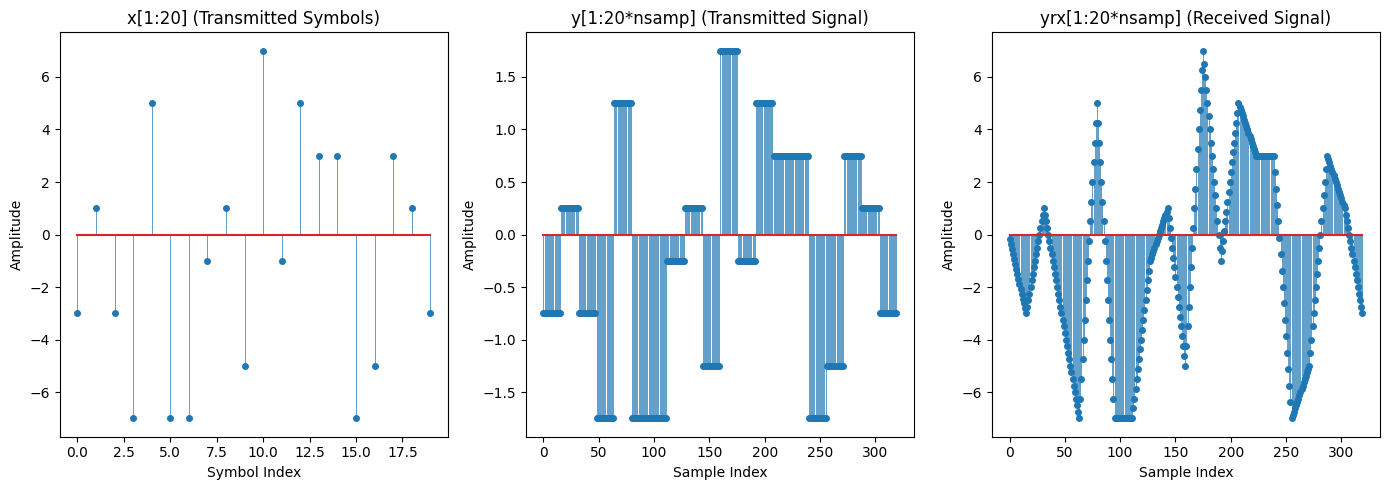

In [14]:
def ask_errors_modified(k, M, nsamp, add_noise=False):
    """
    This function simulates a digital communication system with optional noise addition.

    Parameters:
    - k (int): Number of bits per symbol (determines the modulation order L = 2^k)
    - M (int): Number of symbols to simulate
    - nsamp (int): Number of samples per symbol (oversampling factor)
    - add_noise (bool): If True, adds Additive White Gaussian Noise (AWGN) to the signal

    Returns:
    - x[:20] (ndarray): First 20 transmitted symbols
    - y[:20*nsamp] (ndarray): First 20*nsamp samples of the transmitted signal after pulse shaping
    - yrx[:20*nsamp] (ndarray): First 20*nsamp samples of the received signal after matched filtering
    """
    L = 2 ** k  # Modulation order (number of signal levels)

    # Generate random symbols from the constellation points
    # Symbols range from -L+1 to L-1 with a step of 2
    x = 2 * np.floor(L * np.random.rand(M)) - L + 1

    # Create the filter impulse response (pulse shaping filter)
    # Here, we use a rectangular pulse of duration 'nsamp' with unit energy
    h = np.ones(nsamp) / np.sqrt(nsamp)

    # Sender side: upsample and then convolve (filter) the signal
    # 'upfirdn' performs upsampling, FIR filtering, and downsampling
    y = upfirdn(h, x, up=nsamp)  # Upsample by 'nsamp' and filter with 'h'
    y = y[:M * nsamp]  # Truncate to desired length in case convolution extends the signal

    # Optionally add noise to the transmitted signal
    y_noisy = y
    if add_noise:
        SNR_db = 10  # Example SNR value in dB; adjust as necessary
        SNR_linear = 10 ** (SNR_db / 10)  # Convert SNR from dB to linear scale
        P_x = np.mean(y ** 2)  # Calculate signal power
        noise_variance = P_x / SNR_linear  # Calculate noise variance based on SNR
        # Generate white Gaussian noise
        noise = np.random.normal(0, np.sqrt(noise_variance), len(y))
        y_noisy = y + noise  # Add noise to the transmitted signal

    # Receiver side: matched filtering
    matched = h[::-1]  # Matched filter is the time-reversed version of 'h'
    yrx = convolve(y_noisy, matched, mode='full')  # Convolve received signal with matched filter
    yrx = yrx[:M * nsamp]  # Truncate to desired length

    # Returning slices for visualization (first 20 symbols and corresponding samples)
    return x[:20], y[:20 * nsamp], yrx[:20 * nsamp]


import matplotlib.pyplot as plt

k = 3         # Number of bits per symbol (e.g., k=3 for 8-ASK)
M = 100       # Total number of symbols to simulate
nsamp = 16    # Number of samples per symbol (oversampling factor)

# Get the signal parts for visualization
x_part, y_part, yrx_part = ask_errors_modified(k, M, nsamp, add_noise=False)

# Create a figure and a set of subplots to display the signals
fig, axs = plt.subplots(1, 3, figsize=(14, 5))

# Plot the transmitted symbols x[1:20]
markerline, stemlines, baseline = axs[0].stem(x_part)
plt.setp(stemlines, 'linewidth', 0.5)    # Set the stem lines' width
plt.setp(markerline, 'markersize', 4)    # Set the marker size
axs[0].set_title('x[1:20] (Transmitted Symbols)')
axs[0].set_xlabel('Symbol Index')
axs[0].set_ylabel('Amplitude')

# Plot the transmitted signal after pulse shaping y[1:20*nsamp]
markerline, stemlines, baseline = axs[1].stem(y_part)
plt.setp(stemlines, 'linewidth', 0.5)
plt.setp(markerline, 'markersize', 4)
axs[1].set_title('y[1:20*nsamp] (Transmitted Signal)')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Amplitude')

# Plot the received signal after matched filtering yrx[1:20*nsamp]
markerline, stemlines, baseline = axs[2].stem(yrx_part)
plt.setp(stemlines, 'linewidth', 0.5)
plt.setp(markerline, 'markersize', 4)
axs[2].set_title('yrx[1:20*nsamp] (Received Signal)')
axs[2].set_xlabel('Sample Index')
axs[2].set_ylabel('Amplitude')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


Write a brief explanation of the second and third diagrams.

(c) Replace the rectangular pulse h with another, e.g., a cosine of one period: 
$$
h=cos(2*pi*(1:nsamp)/nsamp); h=h/sqrt(h*h’);
$$

Execute the simulation again with bertool. What is the conclusion about the performance of the new L-ASK system? If we revert the command matched=h for the matched filter, we will observe that we do not get correct results, especially for small values of nsamp (e.g., nsamp=8). Explain this, after observing the shape of the pulse h in the two cases (rectangular pulse and sine pulse), plotting it with stems (stem(h)). Repeat the experiment for nsamp=32 and 64.

Reset matched=h for the matched filter. You will see that we do not get right results for low values
of nsamp (e.g. nsamp=8). Can you explain why is that?

In [15]:
# Loading animation HTML code for visual feedback during processing
# This HTML code creates a spinning loader animation to indicate that processing is ongoing

loading = """
    <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
        <div class='loader' style='border: 12px solid #f3f3f3; /* Light grey */
                                     border-top: 12px solid #01cc97; /* Blue */
                                     border-radius: 50%;
                                     width: 40px;
                                     height: 40px;
                                     animation: spin 2s linear infinite;'></div>
    </div>
    <style>
    @keyframes spin {
        0% { transform: rotate(0deg); }     /* Start rotation at 0 degrees */
        100% { transform: rotate(360deg); } /* Full rotation (360 degrees) */
    }
    </style>
    """

# HTML code to display a checkmark when loading is complete
# This code shows a green checkmark indicating that processing has finished

done = """
        <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
            <div style='font-size: 40px; color: #01cc97;'>&#10003;</div>  <!-- Unicode checkmark symbol -->
        </div>
        """

# Create HTML widgets to display the loading animation and elapsed time
loader_html5 = widgets.HTML(
  value=loading  # Initially display the loading animation
)
timer_html5 = widgets.HTML(
    value="Elapsed time: - seconds"  # Placeholder for the elapsed time display
)

def ask_errors_sin_wrong(k, M, nsamp, EbN0_db, matched_filter_type='Normal'):
    """
    This function simulates an ASK communication system using a cosine-shaped pulse
    and calculates the number of symbol errors.

    Parameters:
    - k (int): Number of bits per symbol (determines the modulation order L = 2^k)
    - M (int): Number of symbols to simulate
    - nsamp (int): Number of samples per symbol (oversampling factor)
    - EbN0_db (float): Energy per bit to noise power spectral density ratio in decibels
    - matched_filter_type (str): Type of matched filter to use ('Normal' or 'Reversed')

    The function performs the following steps:
    1. Generates random symbols according to the specified modulation order.
    2. Uses a cosine-shaped pulse for pulse shaping.
    3. Upsamples the signal and filters it with the pulse shape.
    4. Adds white Gaussian noise to the signal based on the specified Eb/N0.
    5. Passes the noisy signal through a matched filter.
    6. Samples the matched filter output at the symbol rate.
    7. Demodulates the signal by finding the closest symbol level.
    8. Counts the number of symbol errors.

    Returns:
    - errors (int): The number of symbol errors detected.
    """

    # Modulation order
    L = 2 ** k

    # Adjust SNR based on the oversampling factor and bits per symbol
    SNR_db = EbN0_db - 10 * np.log10(nsamp / (2 * k))
    SNR_linear = 10 ** (SNR_db / 10)  # Convert SNR from dB to linear scale

    # Generate random symbols from the constellation points
    x = 2 * np.floor(L * np.random.rand(M)) - L + 1  # Symbols from -L+1 to L-1, step 2

    # Create the pulse shaping filter using a cosine function
    # The pulse h is a cosine-shaped pulse over 'nsamp' samples
    h = np.cos(2 * np.pi * np.arange(1, nsamp + 1) / nsamp)
    h = h / np.sqrt(np.sum(h ** 2))  # Normalize the pulse to have unit energy

    # Sender side: upsample and then convolve (filter) the signal
    y = upfirdn(h, x, up=nsamp)  # Upsample by 'nsamp' and filter with 'h'
    y = y[:M * nsamp]  # Truncate to desired length

    # Calculate signal power for noise calculation
    P_x = np.mean(y ** 2)
    noise_variance = P_x / SNR_linear  # Noise variance based on SNR

    # Generate white Gaussian noise
    noise = np.random.normal(0, np.sqrt(noise_variance), len(y))
    y_noisy = y + noise  # Add noise to the transmitted signal

    # Receiver side: matched filtering
    # Use either the normal pulse or its time-reversed version based on 'matched_filter_type'
    matched = h[::-1] if matched_filter_type == 'Reversed' else h
    yrx = np.convolve(y_noisy, matched, mode='full')

    # Sampling at the symbol rate (every 'nsamp' samples)
    z = yrx[nsamp - 1:M * nsamp:nsamp]

    # Decision making (Demodulation)
    levels = np.arange(-L + 1, L, 2)  # Possible symbol levels
    # For each sample, find the closest symbol level
    z_decided = levels[np.abs(levels[:, None] - z).argmin(axis=0)]

    # Count symbol errors
    errors = np.count_nonzero(x != z_decided)

    return errors

# Create a RadioButtons widget for selecting the matched filter type
matched_radio = RadioButtons(
    options=['Normal', 'Reversed'],  # Options for matched filter type
    value='Normal',  # Default value
    description='Matched Filter:',
    disabled=False
)

# Simulation parameters
M = 10000  # Number of symbols to simulate
EbN0_db = np.arange(0, 21, 2)  # Eb/N0 values from 0 to 20 dB in steps of 2 dB

# Initialize checkboxes for selecting modulation schemes
checkbox_4ask = Checkbox(value=True, description='4-ASK')   # Checkbox for 4-level ASK modulation
checkbox_8ask = Checkbox(value=False, description='8-ASK')  # Checkbox for 8-level ASK modulation
checkbox_16ask = Checkbox(value=False, description='16-ASK')# Checkbox for 16-level ASK modulation

# Dropdown widget for selecting samples per symbol
nsamp_dropdown = Dropdown(
    options=[4, 8, 16, 32, 64],  # Options for samples per symbol
    value=16,  # Default value
    description='Samples per Symbol:',
    style={'description_width': 'initial'}
)

# Create an output widget to display the plot
plot_output = Output()

def plot_selected_modulations(change):
    """
    This function plots the theoretical and experimental Bit Error Rate (BER) curves
    for selected ASK modulation schemes using a cosine-shaped pulse, based on user-selected
    parameters such as samples per symbol and matched filter type.

    Parameters:
    - change: An event handler parameter (not used in the function body)

    The function performs the following steps:
    1. Retrieves the selected parameters from the widgets.
    2. Iterates over the selected modulation schemes.
    3. For each scheme, computes the experimental BER using 'ask_errors_sin_wrong'.
    4. Computes the theoretical BER for comparison.
    5. Plots both BER curves on a semilog plot.
    """

    # Start timer and show the loading animation
    start_time = time.time()
    loader_html5.value = loading

    with plot_output:
        plot_output.clear_output(wait=True)  # Clear previous output
        nsamp = nsamp_dropdown.value  # Get the selected samples per symbol
        matched_filter_type = matched_radio.value  # Get the selected matched filter type

        plt.figure(figsize=(10, 7))
        colors = {'4-ASK': 'red', '8-ASK': 'green', '16-ASK': 'blue'}

        # Iterate over modulation schemes and corresponding checkboxes
        for k, checkbox, color in zip(
            [2, 3, 4],  # k values for 4-ASK, 8-ASK, 16-ASK
            [checkbox_4ask, checkbox_8ask, checkbox_16ask],
            colors.values()
        ):
            if checkbox.value:
                L = 2 ** k  # Modulation order
                modulation_name = f'{L}-ASK'
                ber = np.zeros(len(EbN0_db))  # Initialize BER array

                # Simulate experimental BER for each Eb/N0 value
                for index, eb_n0 in enumerate(EbN0_db):
                    errors = ask_errors_sin_wrong(k, M, nsamp, eb_n0, matched_filter_type)
                    ber[index] = errors / (M * np.log2(L))  # Calculate BER

                # Plot experimental BER
                plt.semilogy(EbN0_db, ber, 'o', label=f'Experimental {modulation_name}', color=color)

                # Theoretical BER for comparison
                EbN0_linear = 10 ** (EbN0_db / 10)  # Convert Eb/N0 from dB to linear scale
                ber_theoretical = (((L - 1) / L) * erfc(
                    np.sqrt(EbN0_linear * (3 * np.log2(L)) / (L ** 2 - 1))
                )) / k

                plt.semilogy(EbN0_db, ber_theoretical, linestyle='-', label=f'Theoretical {modulation_name}', color=color)

        plt.grid(True, which='both')  # Add grid lines
        plt.xlabel("Eb/N0 (dB)")       # Label for x-axis
        plt.ylabel("BER")              # Label for y-axis
        plt.title(f'Theoretical and Experimental BER of ASK Modulations [nsamp={nsamp}]')
        plt.legend()                   # Display legend

        # Calculate and display the elapsed time
        elapsed_time = time.time() - start_time
        timer_html5.value = f"Elapsed time: {elapsed_time:.2f} seconds"
        loader_html5.value = done  # Replace the loading animation with the completion checkmark

        plt.show()

# Attach the update function to observe changes in checkboxes, dropdown, and radio buttons
checkbox_4ask.observe(plot_selected_modulations, names='value')
checkbox_8ask.observe(plot_selected_modulations, names='value')
checkbox_16ask.observe(plot_selected_modulations, names='value')
nsamp_dropdown.observe(plot_selected_modulations, names='value')
matched_radio.observe(plot_selected_modulations, names='value')

# Arrange the widgets for user input
inputs1 = widgets.HBox([nsamp_dropdown])  # Samples per symbol dropdown
inputs2 = widgets.HBox([matched_radio], layout=Layout(margin="0 0 0 20px"))  # Matched filter radio buttons
inputs12 = widgets.HBox([inputs1, inputs2], layout=Layout(align_items='center'))  # Combine inputs
inputs3 = widgets.VBox([checkbox_4ask, checkbox_8ask, checkbox_16ask])  # Modulation scheme checkboxes

inputs = widgets.VBox([inputs12, inputs3])  # All input widgets

# Group the loader and timer together
loader_timer_box = widgets.VBox([loader_html5, timer_html5])

# Arrange the inputs and loader/timer horizontally
ui = widgets.HBox([inputs, loader_timer_box], layout=Layout(align_items='center'))

# Display the widgets and the output container
display(ui, plot_output)

# Call the function initially to display the plot
plot_selected_modulations(None)


Output()

Plot pulse h with nsamp 8 and 16,
orthogonal and sinusoidal. Use stem(h). Repeat for nsamp=32 and 64.

In [17]:
# Loading animation HTML code for visual feedback during processing
# This HTML code creates a spinning loader animation to indicate that processing is ongoing
loading = """
    <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
        <div class='loader' style='border: 12px solid #f3f3f3; /* Light grey border */
                                     border-top: 12px solid #01cc97; /* Blue border on top */
                                     border-radius: 50%;             /* Circular shape */
                                     width: 40px;
                                     height: 40px;
                                     animation: spin 2s linear infinite; /* Spinning animation */'></div>
    </div>
    <style>
    @keyframes spin {
        0% { transform: rotate(0deg); }     /* Start rotation at 0 degrees */
        100% { transform: rotate(360deg); } /* Full rotation (360 degrees) */
    }
    </style>
    """

# HTML code to display a checkmark when loading is complete
# This code shows a green checkmark indicating that processing has finished
done = """
    <div style='display: flex; justify-content: center; align-items: center; height: 80px;'>
        <div style='font-size: 40px; color: #01cc97;'>&#10003;</div>  <!-- Unicode checkmark symbol -->
    </div>
    """

# Create HTML widgets to display the loading animation and elapsed time
loader_html6 = widgets.HTML(
    value=loading  # Initially display the loading animation
)
timer_html6 = widgets.HTML(
    value="Elapsed time: - seconds"  # Placeholder for the elapsed time display
)

# Create an output widget to display the plot
output = widgets.Output()

# Define a function to plot the filters when the nsamp value changes
def plot_filters(change):
    """
    This function plots the orthogonal and sinusoidal pulse shaping filters,
    as well as their matched filters. It updates the plots based on the selected
    number of samples per symbol (nsamp).

    Parameters:
    - change: An event handler parameter (not used in the function body)
    """
    # Start timer and show the loading animation
    start_time = time.time()
    nsamp = nsamp_input.value  # Get the selected nsamp value from the dropdown

    with output:
        loader_html6.value = loading  # Display the loading animation
        output.clear_output(wait=True)  # Clear previous output

        # Define the orthogonal pulse shaping filter
        # It is a rectangular pulse of duration 'nsamp' with unit energy
        orthogonal = np.ones(nsamp) / np.sqrt(nsamp)

        # Define the sinusoidal pulse shaping filter
        # It is a cosine function over 'nsamp' samples, normalized to unit energy
        sinusoidal = np.cos(2 * np.pi * np.arange(1, nsamp + 1) / nsamp)
        sinusoidal = sinusoidal / np.sqrt(np.sum(sinusoidal ** 2))  # Normalize to unit energy

        # Define the matched filters (time-reversed versions)
        matched_orthogonal = orthogonal[::-1]  # Time-reversed orthogonal filter
        matched_sinusoidal = sinusoidal[::-1]  # Time-reversed sinusoidal filter

        # Create subplots to display the filters
        fig, axs = plt.subplots(2, 2, figsize=(14, 8))

        # Plot the orthogonal filter
        markerline, stemlines, baseline = axs[0, 0].stem(orthogonal)
        plt.setp(stemlines, 'linewidth', 0.5)  # Adjust line width
        plt.setp(markerline, 'markersize', 4)  # Adjust marker size
        axs[0, 0].set_title('Orthogonal Pulse Shaping Filter')
        axs[0, 0].set_xlabel('Sample Index')
        axs[0, 0].set_ylabel('Amplitude')

        # Plot the sinusoidal filter
        markerline, stemlines, baseline = axs[0, 1].stem(sinusoidal)
        plt.setp(stemlines, 'linewidth', 0.5)
        plt.setp(markerline, 'markersize', 4)
        axs[0, 1].set_title('Sinusoidal Pulse Shaping Filter')
        axs[0, 1].set_xlabel('Sample Index')
        axs[0, 1].set_ylabel('Amplitude')

        # Plot the matched orthogonal filter
        markerline, stemlines, baseline = axs[1, 0].stem(matched_orthogonal)
        plt.setp(stemlines, 'linewidth', 0.5)
        plt.setp(markerline, 'markersize', 4)
        axs[1, 0].set_title('Matched Orthogonal Filter')
        axs[1, 0].set_xlabel('Sample Index')
        axs[1, 0].set_ylabel('Amplitude')

        # Plot the matched sinusoidal filter
        markerline, stemlines, baseline = axs[1, 1].stem(matched_sinusoidal)
        plt.setp(stemlines, 'linewidth', 0.5)
        plt.setp(markerline, 'markersize', 4)
        axs[1, 1].set_title('Matched Sinusoidal Filter')
        axs[1, 1].set_xlabel('Sample Index')
        axs[1, 1].set_ylabel('Amplitude')

        plt.tight_layout()  # Adjust layout to prevent overlap

        # Calculate and display the elapsed time
        elapsed_time = time.time() - start_time
        timer_html6.value = f"Elapsed time: {elapsed_time:.2f} seconds"
        loader_html6.value = done  # Replace loading animation with completion checkmark

        plt.show()  # Display the plots

# Widget UI component: Dropdown for selecting nsamp
nsamp_input = widgets.Dropdown(
    options=[8, 16, 32, 64],  # Possible values for nsamp
    value=8,  # Default value
    description='nsamp:',  # Label for the dropdown
)

# Attach the plot_filters function to the nsamp_input widget
nsamp_input.observe(plot_filters, names='value')

# Arrange the input widget vertically
inputs = widgets.VBox([nsamp_input])

# Group the loader and timer together with a margin
loader_timer_box = widgets.VBox(
    [loader_html6, timer_html6],
    layout=widgets.Layout(margin='0 0 0 20px', width='auto')
)

# Arrange the UI components horizontally
ui = widgets.HBox(
    [inputs, loader_timer_box],
    layout=Layout(align_items='center')  # Center alignment
)

# Combine the UI and output area
out = widgets.VBox([ui, output])

# Display the user interface
display(out)

# Initial call to plot the filters with default nsamp value
plot_filters(None)
